In [348]:
#@Author Corentin

In [349]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, networkx as nx

# Creation de deux classe: Fitness et City

La classe city va créer une ville avec des coordonnées, une méthode (avec comme paramètre elle même et une ville) afin de calculer sa distance avec une ville et une autre méthode afin de renvoyer une coordonnée nettoyé. 

In [350]:
class City:
    def __init__(self, x, y, i):
        self.x = x
        self.y = y
        self.i = i
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.i) + ": " + str(self.x) + "," + str(self.y) + ")"

La classe fitness va contenir 3 méthodes : 
- La première initialise une route avec une distance et un fitness égale à 0
- La deuxieme calcule les distances des routes voisines en prenant en compte que nous devons revenir à note sommet de départ.
- La troisième calcul le fitness du chemin qui est empruntée. Elle prend l'inverse de la distance calculée ci-dessus, en effet, plus une distance est petite, plus son fitness est élevé. 


In [351]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

# Création de la population :

Nous allons créer notre population. Pour cela, nous allons créer une fonction qui produit des itinéraires qui répondent aux conditions. Pour créer un individu, nous selectionnons au hasard l'ordre dans lequel nous visitons chaque ville :   

In [352]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

La fonction ci-dessus nous produit un individu, mais dans notre cas, nous voulons une population complète, donc nous implémenterons une liste vide qui contiendra une population initiale, mais aussi une boucle qui de 0 à une taille de population voulu, va créer un individu et le mettra dans la liste qu'il retournera à la fin. 

In [353]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

# Determination du fitness 

Le fitness est le score qui va définir si oui ou non cette route est plus viable que les autres. Nous allons don créer une fonction qui "simulera la survie des individus les plus aptes", et donc qui classera chaque individu de la population ci-dessus. La sortie de cette fonction retournera une liste triée avec les identifiants des itinéraires et chaque score de fitness associé. 

In [354]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

# Séléction du pool de reproduction

Il existe quelques options pour sélectionner les parents qui seront utilisés pour créer la prochaine génération. Les approches les plus courantes sont soit la sélection proportionnelle de la condition physique (alias «sélection de la roulette») ou la sélection de tournoi: 
- La sélection proportionnelle de la forme physique (la version implémentée ci-dessous): La forme physique de chaque individu par rapport à la population est utilisée pour attribuer une probabilité de sélection. 
- Sélection du tournoi: Un certain nombre d'individus sont sélectionnés au hasard dans la population et celui avec la meilleure forme physique du groupe est choisi comme premier parent. Ceci est répété pour choisir le deuxième parent. 

Une autre caractéristique de conception à considérer est l'utilisation de l'élitisme. Avec l'élitisme, les individus les plus performants de la population passeront automatiquement à la génération suivante, garantissant la persistance des individus les plus performants.

Par souci de clarté, nous allons créer le pool de couplage en deux étapes. Tout d'abord, nous utiliserons la sortie de rankRoutes pour déterminer les itinéraires à sélectionner dans notre fonction de sélection. 
Dans les lignes 3 à 5, nous avons configuré la roulette en calculant un poids relatif de fitness pour chaque individu. À la ligne 9, nous comparons un nombre tiré au hasard à ces poids pour sélectionner notre pool d'accouplements. Nous souhaitons également conserver nos meilleures routes. 

Nous introduisons donc l'élitisme à la ligne 7. En fin de compte, la fonction de sélection renvoie une liste d'ID de route, que nous pouvons utiliser pour créer le pool de correspondances dans la fonction matingPool.

In [355]:
def selection(popRanked, eliteSize):
    #Liste vide des resultats 
    selectionResults = []
    #init d'un dataframe contenant notre population (avec un colonne ID et une avec son score Fitness)
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    #ajout d'une colonne avec la valeur du fitness cumulé avec ceux ci-dessus
    df['cum_sum'] = df.Fitness.cumsum()
    #ajout d'une colonne avec le pourcentage de prise de cette individu. 
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    #ajout d'un ou des membre(s) élite(s) dans notre selection
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    #choix de manière aléatoire d'individu (en fonction de son pourcentage)
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Maintenant que nous avons les ID des routes qui constituront notre pool d'accouplement, nous allons pouvoir créer notre pool d'accouplement. Pour cela, nous allons simplement extraire les individus selectionnées dans notre population. 

In [356]:
def matingPool(population, selectionResults):
    #liste des choix 
    matingpool = []
    #Pour tout element des resultats, si l'index est égale à l'index de la selection, on l'ajoute dons notre liste
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

# La reproduction

In [357]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Ensuite, nous généraliserons cela pour créer notre population de descendants. À la ligne 5, nous utilisons l'élitisme pour conserver les meilleurs itinéraires de la population actuelle. Ensuite, à la ligne 8, nous utilisons la fonction d'accouplement pour remplir le reste de la prochaine génération.

In [358]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

# Mutation 

La mutation servira à nous éloigner d'une convergance local en introduisant des nouvelles routes qui nous permetterons d'explorer d'une partie de l'espace des solutions. 

In [359]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
            
    return individual

Ensuite, nous pouvons étendre la fonction de mutation pour parcourir la nouvelle population. 

In [360]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

# Repetition

L'algorithme est presque complet, il faut rassembler les fonctions et méthodes que nous avons créer pour produire des nouvelles génération. Premièrement: 
- Nous classons les itinéraires de la génération actuelle à l'aide de rankRoutes. 
- Nous déterminons ensuite nos parents potentiels en exécutant la fonction de sélection, qui nous permet de créer le pool de couplage à l'aide de la fonction matingPool. 
- Enfin, nous créons ensuite notre nouvelle génération en utilisant la fonction racePopulation puis en appliquant une mutation en utilisant la fonction mutatePopulation.

In [361]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

# Evolution en mouvement

Nous avons tout ce qu'il faut pour mettre en place l'algorithme. Tout ce que nous devons faire est de créer la population initiale, puis nous pouvons parcourir autant de générations que nous le souhaitons. Bien sûr, nous voulons également voir le meilleur itinéraire et les améliorations que nous avons apportées, nous capturons donc la distance initiale sur la ligne 3 , la distance finale sur la ligne 8 et le meilleur itinéraire en ligne 9.

In [362]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    return bestRoute

# Exécuter l'algorithme 

L'execution de l'algorithme se fera en deux étapes : Premièrement, nous avons besoin d'une liste de villes entre lesquelles voyager. Pour cette démonstration, nous allons créer une liste de 25 villes aléatoires (un nombre apparemment petit de villes, mais la bruteforce normalement devrait tester plus de 300 sextillions de routes!):


In [370]:
cityList = []
G = nx.Graph()

for i in range(0,100):
    xpos = int(random.random() * 200)
    ypos = int(random.random() * 200)
    cityList.append(City(xpos, ypos, i+1))
    G.add_node(i+1, pos=(xpos, ypos))

Ensuite, l'exécution de l'algorithme génétique est une simple ligne de code. Dans cet exemple, nous avons 100 individus dans chaque génération, gardons 20 individus d'élite, utilisons un taux de mutation de 1% pour un gène donné et parcourons 500 générations:

Initial distance: 4425.599687273329
Final distance: 2747.01707501058


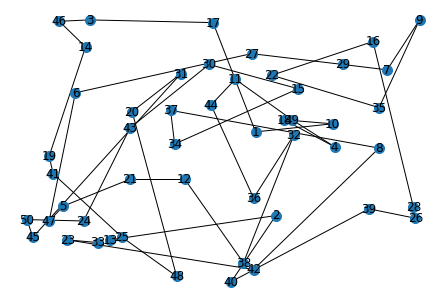

[(33: 35,34),
 (23: 20,36),
 (42: 112,14),
 (8: 174,104),
 (37: 71,132),
 (34: 73,107),
 (15: 134,148),
 (30: 90,166),
 (43: 51,119),
 (24: 28,50),
 (50: 0,51),
 (45: 3,38),
 (31: 76,159),
 (20: 52,131),
 (48: 74,9),
 (25: 47,38),
 (41: 13,85),
 (19: 11,98),
 (14: 29,179),
 (46: 16,198),
 (3: 31,199),
 (17: 92,197),
 (1: 113,116),
 (10: 151,122),
 (18: 127,125),
 (4: 152,105),
 (49: 131,125),
 (11: 103,155),
 (44: 91,136),
 (36: 112,67),
 (32: 132,114),
 (38: 107,19),
 (12: 78,81),
 (21: 51,81),
 (5: 18,61),
 (47: 11,50),
 (6: 24,145),
 (27: 111,174),
 (29: 156,166),
 (7: 178,162),
 (9: 194,199),
 (35: 174,134),
 (22: 121,158),
 (16: 171,183),
 (28: 191,60),
 (26: 192,52),
 (39: 169,59),
 (40: 101,5),
 (2: 123,54),
 (13: 41,36)]

In [265]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100)

# Bonus : Afficher graphiquement l'amélioration

In [365]:
import time, math
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    firstBestRoute = rankRoutes(pop)[0]
    print("Initial distance: " + str(1 / firstBestRoute[1]))
    progress = []
    progress.append(1 / firstBestRoute[1])
    # Setting the best route with the best initial route data
    bestRoute = pop[firstBestRoute[0]]
    shortestDist = progress[0]
    
    genCount = 0
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        currentBest = rankRoutes(pop)[0]
        currentShortestDistance = 1 / currentBest[1]
        progress.append(currentShortestDistance)
        # If this generation's best route has a shorter distance, we register it as the best route known.
        if (shortestDist > currentShortestDistance):
            bestRoute = pop[currentBest[0]]
            shortestDist = currentShortestDistance
        genCount+=1
        if genCount%1000 == 0: 
            print(str(genCount))
            print("--- %s seconds ---" % (time.time() - start_time))
            
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    print("Shortest distance: " + str(shortestDist))
    
    # Drawing the best route graph
    G.remove_edges_from(list(G.edges()))
    hour = 5 # We start the day at 5 am
    totalTravelTime = 0
    for node_index, city in enumerate(bestRoute):
        if node_index + 1 < len(bestRoute):
            nextCity = bestRoute[node_index+1]
            pathDistance = city.distance(nextCity) # Distance between next and current city
            # Calculating how much time we lose in trafic
            travelTimeMalus = (pathDistance / 100)*((evolution_heure_arete[node_index][int(math.floor(hour))])/10000)
            travelTime = (pathDistance / 100) + travelTimeMalus
            # We increase the current hour with the time spent traveling
            hour += travelTime
            totalTravelTime += travelTime
            if hour > 24: hour -= 24
            # Edge color determination
            color = "g"
            if travelTimeMalus>0: color = "y"
            if (travelTimeMalus / travelTime) > 0.7: color = "r"
            # We add the edge to the graph
            G.add_edge(city.i, nextCity.i, color=color)
    
    # First subplot (progress graph)
    plt.subplot(2,1,1)
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    # Graph's dimensions
    plt.figure(figsize=(15,30))
    # Second subplot (route graph)
    plt.subplot(2,1,1)
    pos = nx.get_node_attributes(G, 'pos')
    colors = nx.get_edge_attributes(G,'color').values()
    nx.draw(G, pos, edge_color=colors, node_size=100, with_labels=True)
    
    plt.show()
    
    return bestRoute

Initial distance: 9935.86193795556
1000
--- 38.83540463447571 seconds ---
Final distance: 2922.5144949164055
Shortest distance: 2903.4665738706785


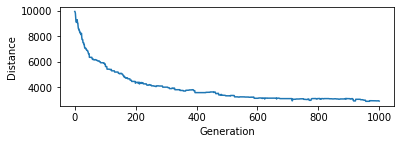

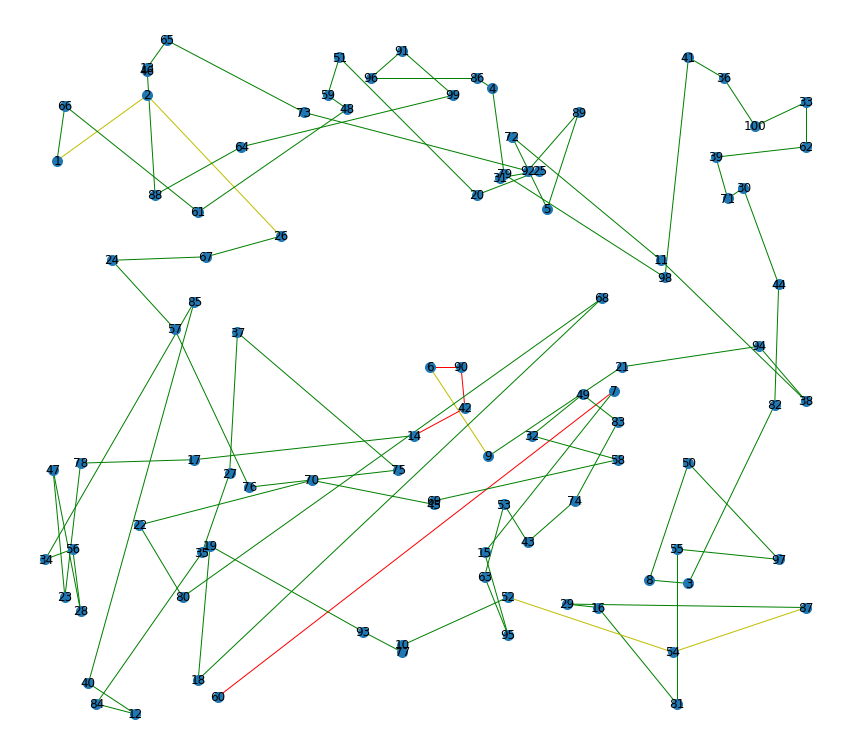

[(31: 116,156),
 (25: 126,158),
 (20: 110,151),
 (51: 75,191),
 (59: 72,180),
 (48: 77,176),
 (61: 39,146),
 (66: 5,177),
 (1: 3,161),
 (2: 26,180),
 (26: 60,139),
 (67: 41,133),
 (24: 17,132),
 (57: 33,112),
 (76: 52,66),
 (75: 90,71),
 (37: 49,111),
 (27: 47,70),
 (35: 40,47),
 (84: 13,3),
 (12: 23,0),
 (40: 11,9),
 (85: 38,120),
 (34: 0,45),
 (56: 7,48),
 (28: 9,30),
 (47: 2,71),
 (23: 5,34),
 (78: 9,73),
 (17: 38,74),
 (14: 94,81),
 (42: 107,89),
 (90: 106,101),
 (6: 98,101),
 (9: 113,75),
 (21: 147,101),
 (94: 182,107),
 (38: 194,91),
 (11: 157,132),
 (72: 119,168),
 (5: 128,147),
 (89: 136,175),
 (92: 123,158),
 (73: 66,175),
 (65: 31,196),
 (13: 26,188),
 (46: 26,187),
 (88: 28,151),
 (64: 50,165),
 (99: 104,180),
 (91: 91,193),
 (96: 83,185),
 (86: 110,185),
 (4: 114,182),
 (79: 117,157),
 (98: 158,127),
 (41: 164,191),
 (36: 173,185),
 (100: 181,171),
 (33: 194,178),
 (62: 194,165),
 (39: 171,162),
 (71: 174,150),
 (30: 178,153),
 (44: 187,125),
 (82: 186,90),
 (3: 164,38),
 (

In [235]:
start_time = time.time()
geneticAlgorithmPlot(population=cityList, popSize=50, eliteSize=15, mutationRate=0.001, generations=1000)

<function matplotlib.pyplot.show(*args, **kw)>

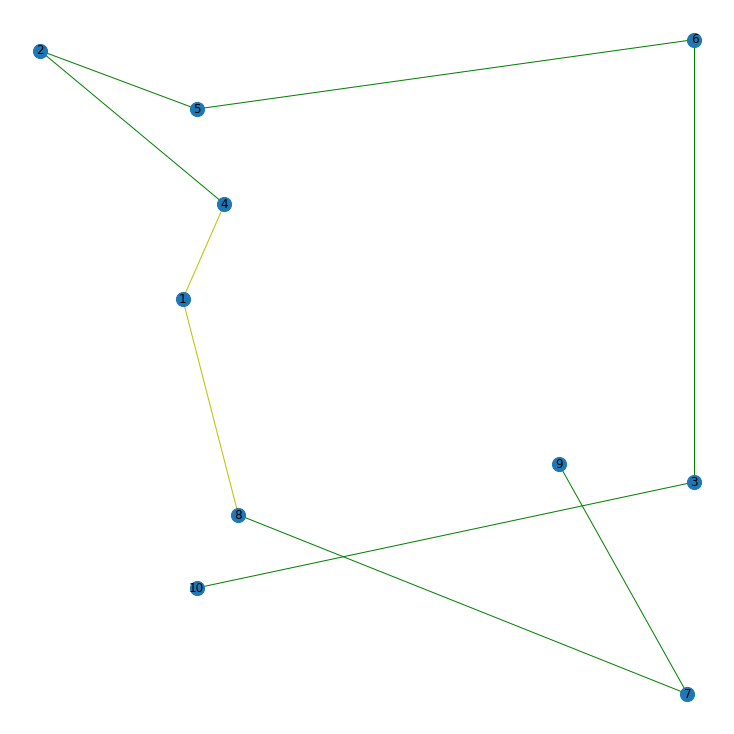

In [231]:
plt.figure(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
colors = nx.get_edge_attributes(G,'color').values()
nx.draw(G, pos, edge_color=colors, node_size=200, with_labels=True)
plt.show

In [366]:
import pandas as pd
import numpy as np
from pymongo import MongoClient


client = MongoClient('localhost', 27017)
db = client['DataProject']
collection_trafic_stamped = db['vehicules_stamped']
vehicules_par_heure_et_arete=[]
for h in range (24):
    temp = (list(db.vehicules_stamped.aggregate([
        {"$project":{"num_arete":1, "heures":{"$hour":"$datetime"}, "nb_vehicules":1}},
        {"$match":{"heures":{"$lte":h, "$gte":h}}},
        {"$group":{"_id":"$num_arete", 
                   "nb_vehicules":{"$sum":"$nb_vehicules"}}},
        {"$sort":{"_id":1}}
    ])))
    vehicules_par_heure_et_arete.append(temp)

In [367]:
evolution_heure_arete=[]
for a in range(500):
    temp=[]
    for h in vehicules_par_heure_et_arete:
        if len(h)!=0:
            temp.append(h[a]["nb_vehicules"])
        else:
            temp.append(0)
    evolution_heure_arete.append(temp)

print(evolution_heure_arete)

[[0, 0, 0, 0, 0, 0, 0, 13559, 21351, 0, 0, 0, 0, 0, 0, 0, 0, 32396, 17762, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 13295, 22061, 0, 0, 0, 0, 0, 0, 0, 0, 35297, 27613, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 14187, 24071, 0, 0, 0, 0, 0, 0, 0, 0, 35616, 27880, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 13678, 23285, 0, 0, 0, 0, 0, 0, 0, 0, 34364, 24990, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 13840, 24796, 0, 0, 0, 0, 0, 0, 0, 0, 32033, 17725, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 14192, 24792, 0, 0, 0, 0, 0, 0, 0, 0, 34205, 24530, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 14543, 26957, 0, 0, 0, 0, 0, 0, 0, 0, 31900, 17978, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 14769, 27076, 0, 0, 0, 0, 0, 0, 0, 0, 33763, 24339, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 15839, 30478, 0, 0, 0, 0, 0, 0, 0, 0, 31927, 18770, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 15526, 28283, 0, 0, 0, 0, 0, 0, 0, 0, 32591, 18878, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 13458, 23400, 0, 0, 0, 0, 0, 0, 0, 0, 33989, 25196, 0, 0, 0, 0, 0], [0, 0, 0,

13559


# Étude statistique de l'algorithme génétique 

Les représentations graphiques ci-dessous sont tirées de résultats d'exécution multiples de notre algorithme.
<br>
Premièrement, essayons de déterminer l'efficacité de notre algorithme en fonction du nombre de générations

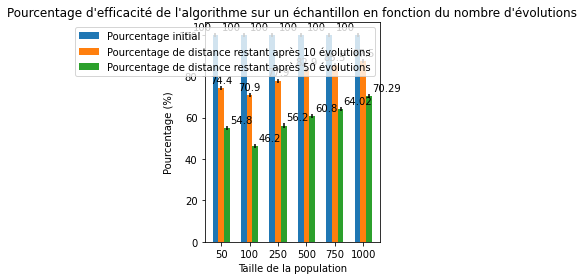

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Valeur des pourcentages
distance_initiale, init_std = (100, 100, 100, 100, 100, 100), (1, 1, 1, 1, 1,1)
distance10, dix_std = (74.4, 70.9, 77.9, 82.9, 85.5, 87.5), (1, 1, 1, 1, 1, 1)
distance50, cinquante_std = (54.8, 46.2,  56.2, 60.8, 64.02, 70.29), (1, 1, 1, 1, 1,1)

ind = np.arange(len(distance_initiale))  # the x locations for the groups
width = 0.20  # the width of the bars

#Création des barres
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, distance_initiale, width, yerr=init_std,
                label='Pourcentage initial')
rects2 = ax.bar(ind, distance10, width, yerr=dix_std,
                label='Pourcentage de distance restant après 10 évolutions')
rects3 = ax.bar(ind + width, distance50, width, yerr=cinquante_std,
                label='Pourcentage de distance restant après 50 évolutions')

# Ajout de texte pour faciliter la compréhension du diagramme
ax.set_ylabel('Pourcentage (%)')
ax.set_xlabel('Taille de la population')
ax.set_title('Pourcentage d\'efficacité de l\'algorithme sur un échantillon en fonction du nombre d\'évolutions')
ax.set_xticks(ind)
ax.set_xticklabels(('50', '100', '250', '500', '750', '1000'))
ax.legend()


def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()
#Affichage de la solution
plt.show()

Calculons quelques valeurs essentielles pour interpréter nos jeux de données. Les instances étant aléatoires, nous essayons ici de nous faire une idée générale des performances à partir de plusieurs exécutions.

In [2]:
import numpy as np


listData = [6567.98, 6567.98, 6532.4, 6504.5, 6508.6, 6612.5, 6628.4, 6720.5, 6498.7, 6547.9, 6531.2, 6554.2, 6568.4, 6698.4, 6541.6, 6529.8, 6537.4, 6518.9, 6538.4, 6478.9, 6547.8, 6598.8, 6687.5, 6524.8, 6528.6, 6537.9]


##Calcul des statistiques descriptives
#Moyenne de la série
moyenne=np.mean(listData)
#Minimum
minimum=min(listData)
#Maximum
maximum=max(listData)
#Médiane
mediane=np.median(listData)
#1er quartile
quartile_1=np.percentile(listData,25)
#3eme quartile
quartile_3=np.percentile(listData,75)
#Variance
variance=np.var(listData)
#Ecart-type
ecart_type=np.std(listData)

##Affichage des résultats en console
print("La moyenne de la série est :", moyenne)
print("Le minimum de la série est :", minimum)
print("Le maximum de la série est :", maximum)
print("La médiane de la série est :", mediane)
print("Le 1er quartile de la série est :", quartile_1)
print("Le 3è quartile de la série est :", quartile_3)
print("La variance de la série est :", variance)
print("L\'écart type de de la série est :", ecart_type)

La moyenne de la série est : 6562.002307692308
Le minimum de la série est : 6478.9
Le maximum de la série est : 6720.5
La médiane de la série est : 6540.0
Le 1er quartile de la série est : 6528.900000000001
Le 3è quartile de la série est : 6568.294999999999
La variance de la série est : 3646.643486982247
L'écart type de de la série est : 60.38744477937651


Ensuite, essayons d'estimer l'impact de la pupolation dans l'exécution de l'algorithme

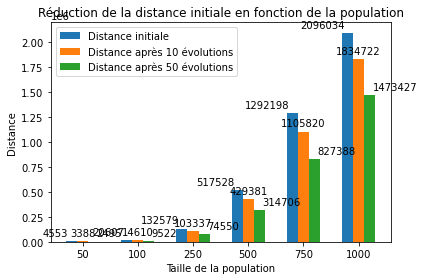

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Définition des valeurs
distance_initiale, init_std = (4553, 20607, 132579, 517528, 1292198, 2096034), (1, 1, 1, 1, 1,1)
distance10, dix_std = (3388, 14610, 103337, 429381, 1105820, 1834722), (1, 1, 1, 1, 1, 1)
distance50, cinquante_std = (2495, 9522,  74550, 314706, 827388, 1473427), (1, 1, 1, 1, 1,1)

ind = np.arange(len(distance_initiale))  # the x locations for the groups
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
#Génération des barres du graphique
rects1 = ax.bar(ind - width, distance_initiale, width, yerr=init_std,
                label='Distance initiale')
rects2 = ax.bar(ind, distance10, width, yerr=dix_std,
                label='Distance après 10 évolutions')
rects3 = ax.bar(ind + width, distance50, width, yerr=cinquante_std,
                label='Distance après 50 évolutions')

# Ajout de texte, légendes, unités afin de faciliter la compréhension du graphes
ax.set_ylabel('Distance')
ax.set_xlabel('Taille de la population')
ax.set_title('Réduction de la distance initiale en fonction de la population')
ax.set_xticks(ind)
ax.set_xticklabels(('50', '100', '250', '500', '750', '1000'))
ax.legend()


def autolabel(rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()
#Affichage de la solution
plt.show()


Enfin, calculon le temps nécessaire en fonction du nombre de villes à parcourir :

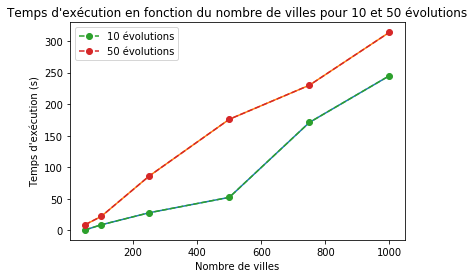

In [379]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Données de génération des deux courbes
#Courbe de 10 évolution par exécution
x = np.array([50, 100, 250, 500, 750, 1000])
y = np.array([0.57, 8.64, 27.8,52.21, 171, 245.12])
#Courbe de 50 évolutions par exécutions
x1 = np.array([50, 100, 250, 500, 750, 1000])
y1 = np.array([8.9, 21.86, 86, 176, 230, 314 ])
#Création des courbes
plt.plot(x, y, x1, y1)

#Ajout de titres et de légendes
title("Temps d'exécution en fonction du nombre de villes pour 10 et 50 évolutions")
plt.xlabel("Nombre de villes")
plt.ylabel("Temps d'exécution (s)")
plt.plot(x, y, "o--", label="10 évolutions")
plt.plot(x1, y1,"o--", label="50 évolutions")
plt.legend()
plt.show() # affiche la figure a l'ecran



# Comparaison des cas de test

En faison varier les paramètres d'entrée, nous avons des résultats très différents.<br>
### Variation de la taille de la population
Temps d'exécution pour 10, 100 et 1000 villes

In [369]:
cityList = []
def testPopulation(nb_villes):
    cityList.clear()
    for i in range(0,nb_villes):
        xpos = int(random.random() * 200)
        ypos = int(random.random() * 200)
        cityList.append(City(xpos, ypos, i+1))

testPopulation(10)
start_time = time.time()
geneticAlgorithm(population=cityList, popSize=50, eliteSize=15, mutationRate=0.001, generations=100)
print("10 villes --- %s seconds ---" % (time.time() - start_time))

testPopulation(100)
start_time = time.time()
geneticAlgorithm(population=cityList, popSize=50, eliteSize=15, mutationRate=0.001, generations=100)
print("100 villes --- %s seconds ---" % (time.time() - start_time))

testPopulation(1000)
start_time = time.time()
geneticAlgorithm(population=cityList, popSize=50, eliteSize=15, mutationRate=0.001, generations=100)
print("1000 villes --- %s seconds ---" % (time.time() - start_time))

Initial distance: 857.9458279315423
Final distance: 618.3428576990925
10 villes --- 0.8024635314941406 seconds ---
Initial distance: 8705.426792092177
Final distance: 5028.657988030499
100 villes --- 2.267216444015503 seconds ---
Initial distance: 99007.7351704264
Final distance: 84980.60223730876
1000 villes --- 28.670605421066284 seconds ---


Les valeurs des temps d'exécutions ci-après n'ont pas été réinitialisée avant leur lancement, les rendants non-pertinentes.

### Variation du taux de mutation
Pour 100 villes, voyons les performances pour différents taux de mutation :

Initial distance: 9656.582104188848
1000
--- 185.43959975242615 seconds ---
Final distance: 9474.505895277469
Shortest distance: 8424.030654771563


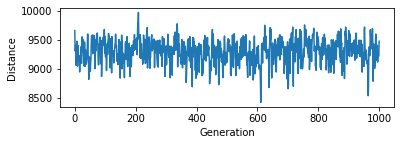

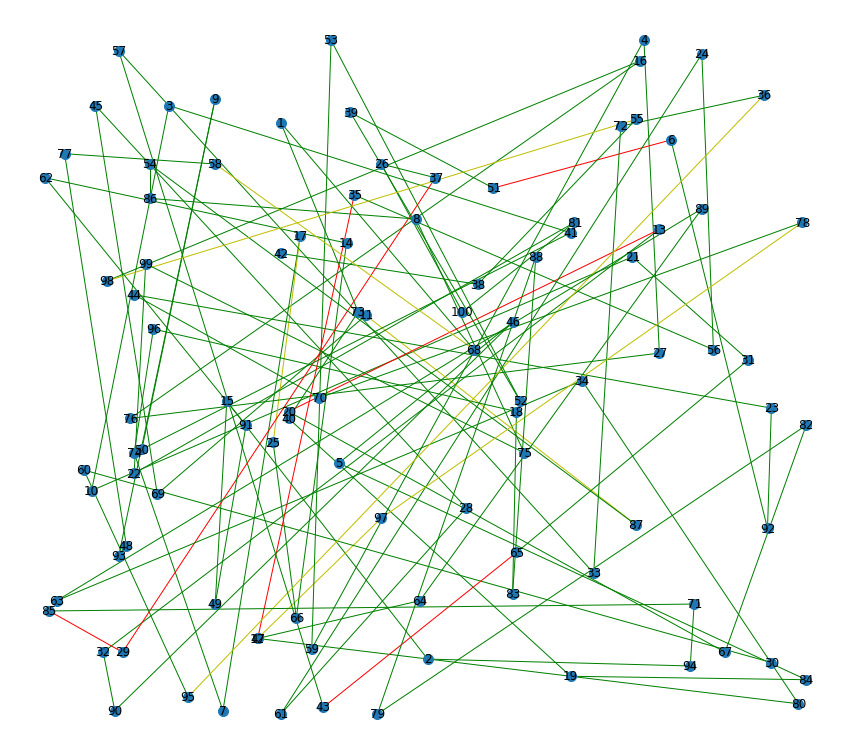

[(30: 189,15),
 (60: 11,71),
 (95: 38,5),
 (36: 187,180),
 (72: 150,171),
 (33: 143,41),
 (57: 20,193),
 (43: 73,2),
 (65: 123,47),
 (31: 183,103),
 (21: 153,133),
 (10: 13,65),
 (3: 33,177),
 (41: 137,140),
 (50: 26,77),
 (9: 45,179),
 (93: 20,46),
 (48: 22,49),
 (77: 6,163),
 (58: 45,160),
 (68: 112,106),
 (1: 62,172),
 (73: 82,117),
 (40: 64,86),
 (19: 137,11),
 (84: 198,10),
 (5: 77,73),
 (46: 122,114),
 (90: 19,1),
 (32: 16,18),
 (13: 160,141),
 (20: 64,88),
 (67: 177,18),
 (82: 198,84),
 (79: 87,0),
 (88: 128,133),
 (83: 122,35),
 (18: 123,88),
 (96: 29,112),
 (74: 24,76),
 (7: 47,1),
 (17: 67,139),
 (25: 60,79),
 (66: 66,28),
 (14: 79,137),
 (62: 1,156),
 (91: 53,84),
 (49: 45,32),
 (15: 48,91),
 (2: 100,16),
 (94: 168,14),
 (71: 169,32),
 (85: 2,30),
 (29: 21,18),
 (37: 102,156),
 (26: 88,160),
 (100: 109,117),
 (81: 138,143),
 (22: 24,70),
 (99: 27,131),
 (75: 125,76),
 (8: 97,144),
 (86: 28,150),
 (54: 28,160),
 (87: 154,55),
 (11: 84,116),
 (69: 30,64),
 (45: 14,177),
 (28: 

In [372]:
geneticAlgorithmPlot(population=cityList, popSize=50, eliteSize=15, mutationRate=0.1, generations=1000)

Ce taux de mutation est beaucoup trop élevé. Diminuons d'un facteur 10 :

Initial distance: 9529.167840723549
1000
--- 239.88753151893616 seconds ---
Final distance: 7337.593272121905
Shortest distance: 6661.604374911332


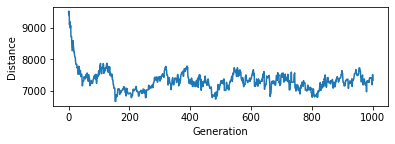

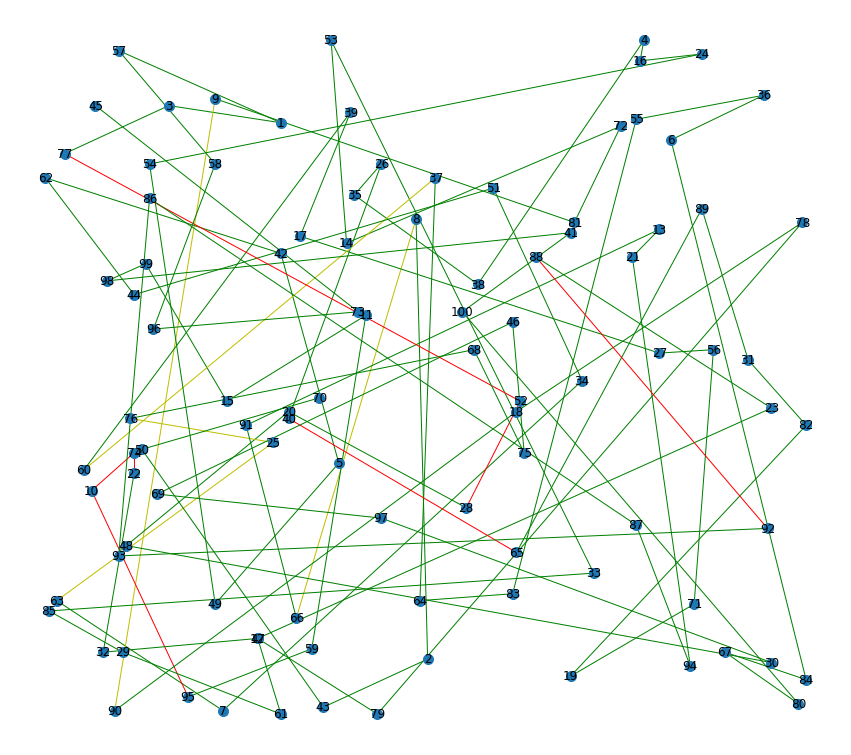

[(70: 72,92),
 (50: 26,77),
 (43: 73,2),
 (2: 100,16),
 (8: 97,144),
 (66: 66,28),
 (91: 53,84),
 (13: 160,141),
 (21: 153,133),
 (94: 168,14),
 (87: 154,55),
 (86: 28,150),
 (93: 20,46),
 (92: 188,54),
 (88: 128,133),
 (23: 189,89),
 (47: 56,22),
 (61: 62,0),
 (29: 21,18),
 (85: 2,30),
 (33: 143,41),
 (53: 75,196),
 (14: 79,137),
 (72: 150,171),
 (81: 138,143),
 (9: 45,179),
 (90: 19,1),
 (18: 123,88),
 (78: 197,143),
 (79: 87,0),
 (12: 56,22),
 (32: 16,18),
 (22: 24,70),
 (74: 24,76),
 (10: 13,65),
 (95: 38,5),
 (59: 70,19),
 (11: 84,116),
 (15: 48,91),
 (99: 27,131),
 (98: 17,126),
 (41: 137,140),
 (100: 109,117),
 (80: 196,3),
 (67: 177,18),
 (84: 198,10),
 (6: 163,167),
 (36: 187,180),
 (55: 154,173),
 (83: 122,35),
 (64: 98,33),
 (37: 102,156),
 (60: 11,71),
 (39: 80,175),
 (17: 67,139),
 (27: 160,105),
 (56: 174,106),
 (71: 169,32),
 (19: 137,11),
 (82: 198,84),
 (31: 183,103),
 (89: 171,147),
 (65: 123,47),
 (40: 64,86),
 (26: 88,160),
 (35: 81,151),
 (38: 113,125),
 (4: 156,19

In [373]:
geneticAlgorithmPlot(population=cityList, popSize=50, eliteSize=15, mutationRate=0.01, generations=1000)

On observe un blocage dans un optimum local. Diminuons encore :

Initial distance: 9938.504803291757
1000
--- 321.3851726055145 seconds ---
Final distance: 3010.9258625780412
Shortest distance: 2992.0672746461355


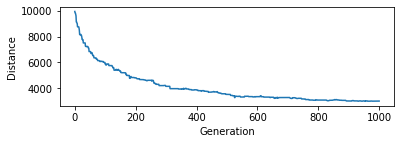

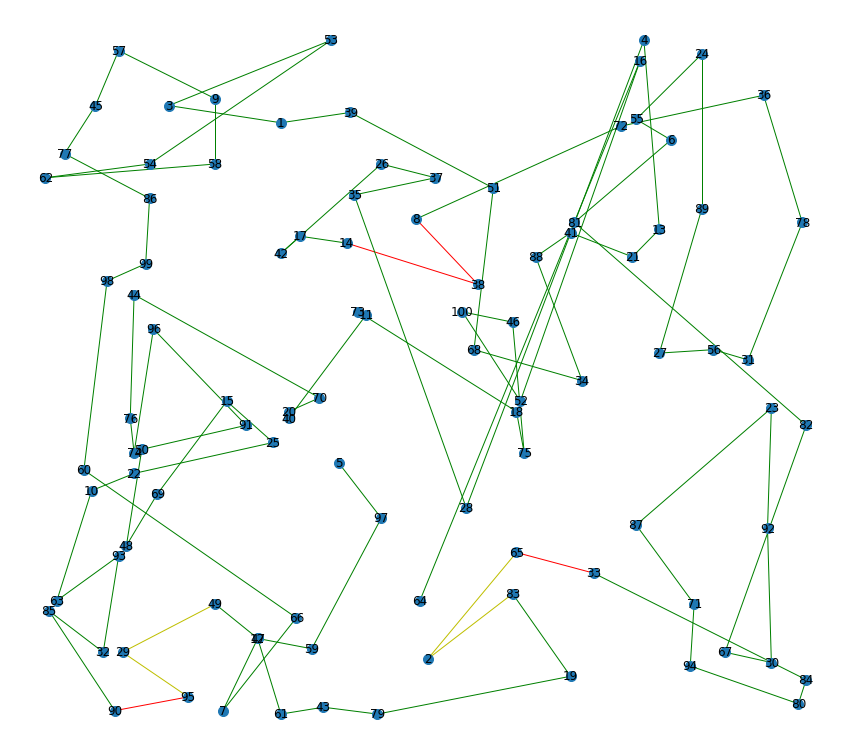

[(5: 77,73),
 (97: 88,57),
 (59: 70,19),
 (12: 56,22),
 (61: 62,0),
 (43: 73,2),
 (79: 87,0),
 (19: 137,11),
 (83: 122,35),
 (2: 100,16),
 (65: 123,47),
 (33: 143,41),
 (84: 198,10),
 (80: 196,3),
 (94: 168,14),
 (71: 169,32),
 (87: 154,55),
 (23: 189,89),
 (92: 188,54),
 (30: 189,15),
 (67: 177,18),
 (82: 198,84),
 (81: 138,143),
 (6: 163,167),
 (55: 154,173),
 (24: 171,192),
 (89: 171,147),
 (27: 160,105),
 (56: 174,106),
 (31: 183,103),
 (78: 197,143),
 (36: 187,180),
 (72: 150,171),
 (8: 97,144),
 (38: 113,125),
 (14: 79,137),
 (17: 67,139),
 (42: 62,134),
 (26: 88,160),
 (37: 102,156),
 (35: 81,151),
 (28: 110,60),
 (4: 156,196),
 (13: 160,141),
 (21: 153,133),
 (41: 137,140),
 (88: 128,133),
 (34: 140,97),
 (68: 112,106),
 (51: 117,153),
 (39: 80,175),
 (1: 62,172),
 (3: 33,177),
 (53: 75,196),
 (54: 28,160),
 (62: 1,156),
 (58: 45,160),
 (9: 45,179),
 (57: 20,193),
 (45: 14,177),
 (77: 6,163),
 (86: 28,150),
 (99: 27,131),
 (98: 17,126),
 (60: 11,71),
 (66: 66,28),
 (7: 47,1),
 

In [374]:
geneticAlgorithmPlot(population=cityList, popSize=50, eliteSize=15, mutationRate=0.001, generations=1000)

Les résultats sont incroyablements plus convaincant avec ce taux de mutation. Le graphe prend une tournure plus intuitive en seulement 1000 générations. Nous garderons ce taux de mutation pour la suite.

### Variation des générations
Si nous augmentons le nombre de générations (de complexité linéaire), nous observerons toutefois un affinage de plus en plus difficile. Prenons l'exemple de 3000 générations:

Initial distance: 9791.380685702796
1000
--- 644.3298420906067 seconds ---
2000
--- 680.5713601112366 seconds ---
3000
--- 716.1707208156586 seconds ---
Final distance: 2606.412412456222
Shortest distance: 2606.412412456221


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


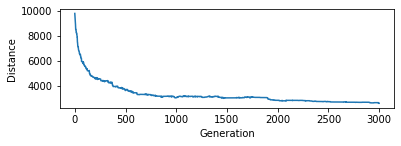

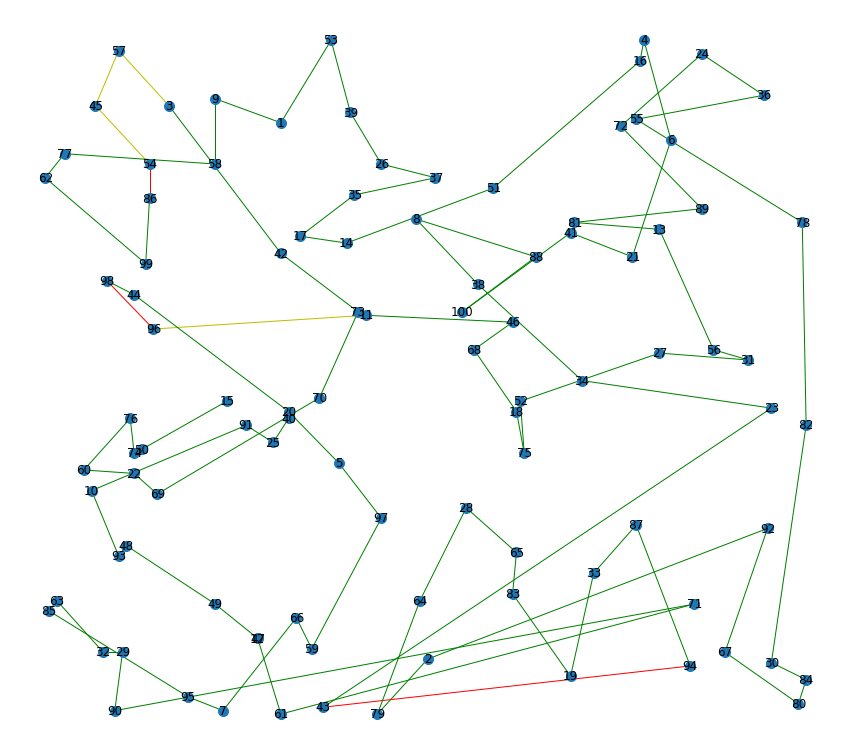

[(15: 48,91),
 (50: 26,77),
 (74: 24,76),
 (76: 23,86),
 (60: 11,71),
 (22: 24,70),
 (69: 30,64),
 (70: 72,92),
 (73: 82,117),
 (42: 62,134),
 (3: 33,177),
 (57: 20,193),
 (45: 14,177),
 (54: 28,160),
 (86: 28,150),
 (99: 27,131),
 (62: 1,156),
 (77: 6,163),
 (58: 45,160),
 (9: 45,179),
 (1: 62,172),
 (53: 75,196),
 (39: 80,175),
 (26: 88,160),
 (37: 102,156),
 (35: 81,151),
 (17: 67,139),
 (14: 79,137),
 (51: 117,153),
 (16: 155,190),
 (4: 156,196),
 (6: 163,167),
 (21: 153,133),
 (41: 137,140),
 (100: 109,117),
 (88: 128,133),
 (8: 97,144),
 (38: 113,125),
 (34: 140,97),
 (23: 189,89),
 (43: 73,2),
 (94: 168,14),
 (87: 154,55),
 (33: 143,41),
 (19: 137,11),
 (83: 122,35),
 (65: 123,47),
 (28: 110,60),
 (64: 98,33),
 (79: 87,0),
 (2: 100,16),
 (92: 188,54),
 (67: 177,18),
 (80: 196,3),
 (84: 198,10),
 (30: 189,15),
 (82: 198,84),
 (78: 197,143),
 (55: 154,173),
 (36: 187,180),
 (24: 171,192),
 (72: 150,171),
 (89: 171,147),
 (81: 138,143),
 (13: 160,141),
 (56: 174,106),
 (31: 183,103

In [376]:
geneticAlgorithmPlot(population=cityList, popSize=50, eliteSize=15, mutationRate=0.001, generations=3000)

### Variation de la taille des elites
Seule la proportions avec le "popSize" est en fait importante (observation faite grâce à de nombreux tests réalisés en amont).
<br>
Reprenons notre test de référence avec 1000 générations :

Initial distance: 10138.618990843323
1000
--- 828.493782043457 seconds ---
Final distance: 3648.5193566288394
Shortest distance: 3493.3103497919105


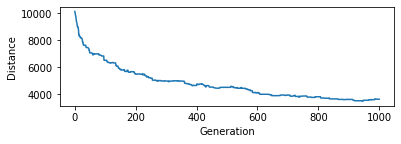

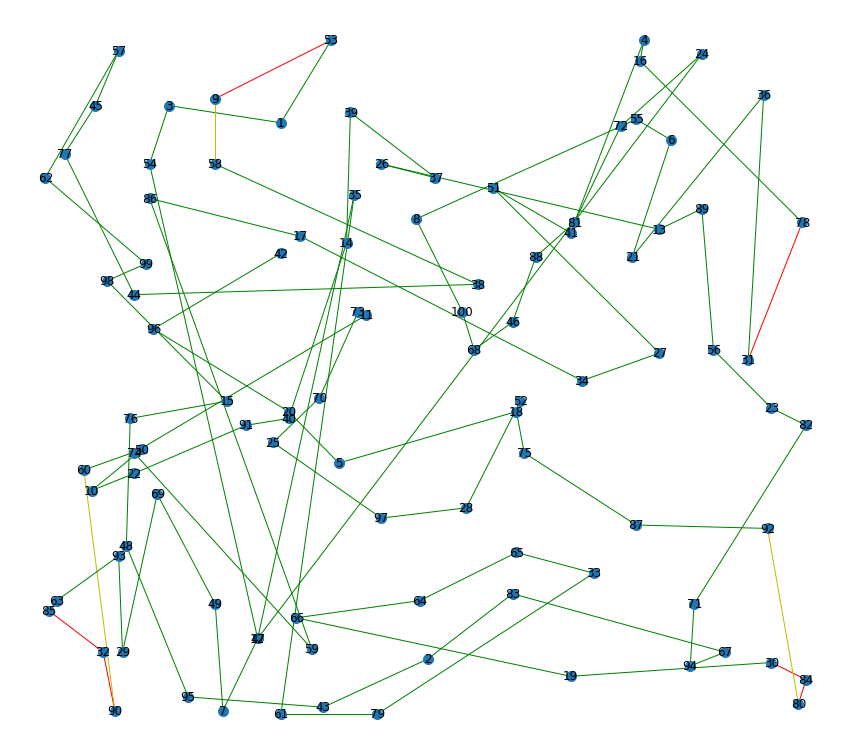

[(42: 62,134),
 (96: 29,112),
 (20: 64,88),
 (5: 77,73),
 (18: 123,88),
 (75: 125,76),
 (87: 154,55),
 (92: 188,54),
 (80: 196,3),
 (84: 198,10),
 (30: 189,15),
 (19: 137,11),
 (66: 66,28),
 (64: 98,33),
 (65: 123,47),
 (33: 143,41),
 (79: 87,0),
 (61: 62,0),
 (35: 81,151),
 (12: 56,22),
 (7: 47,1),
 (49: 45,32),
 (69: 30,64),
 (29: 21,18),
 (93: 20,46),
 (63: 4,33),
 (85: 2,30),
 (32: 16,18),
 (90: 19,1),
 (60: 11,71),
 (50: 26,77),
 (10: 13,65),
 (22: 24,70),
 (91: 53,84),
 (40: 64,86),
 (14: 79,137),
 (39: 80,175),
 (37: 102,156),
 (26: 88,160),
 (13: 160,141),
 (89: 171,147),
 (56: 174,106),
 (23: 189,89),
 (82: 198,84),
 (71: 169,32),
 (94: 168,14),
 (67: 177,18),
 (83: 122,35),
 (2: 100,16),
 (43: 73,2),
 (95: 38,5),
 (48: 22,49),
 (76: 23,86),
 (15: 48,91),
 (98: 17,126),
 (99: 27,131),
 (62: 1,156),
 (57: 20,193),
 (45: 14,177),
 (77: 6,163),
 (44: 24,122),
 (38: 113,125),
 (58: 45,160),
 (9: 45,179),
 (53: 75,196),
 (1: 62,172),
 (3: 33,177),
 (54: 28,160),
 (47: 56,22),
 (24:

In [377]:
geneticAlgorithmPlot(population=cityList, popSize=50, eliteSize=5, mutationRate=0.001, generations=1000)

Avec 10% de gênes "élites", l'algorithme est légèrement moins efficace.

Initial distance: 9419.885151209995
1000
--- 864.4571373462677 seconds ---
Final distance: 3327.0319914687857
Shortest distance: 3286.289528934119


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


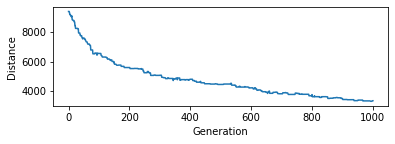

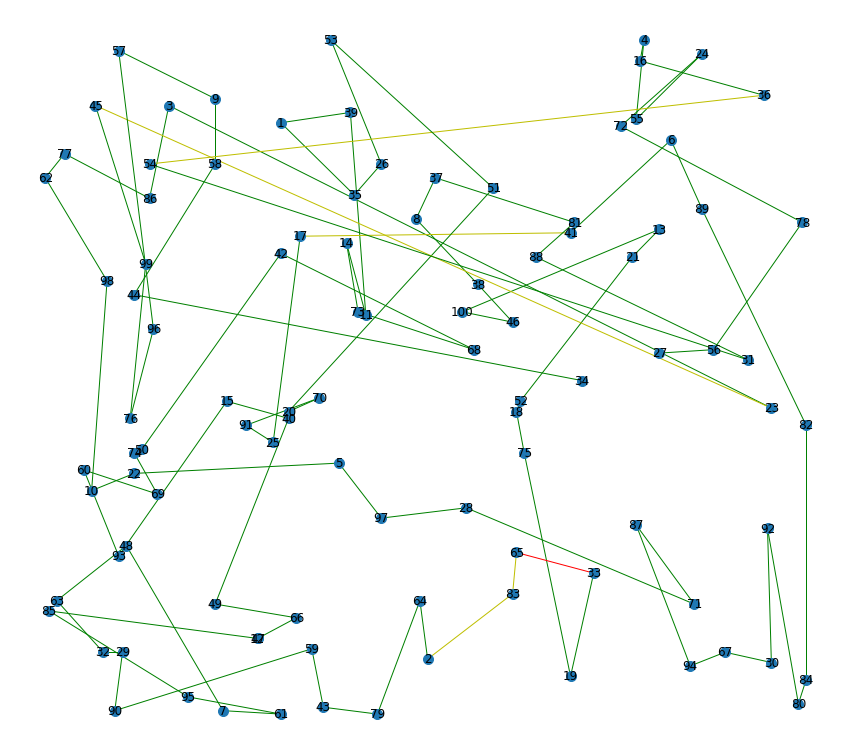

[(27: 160,105),
 (56: 174,106),
 (78: 197,143),
 (72: 150,171),
 (24: 171,192),
 (55: 154,173),
 (4: 156,196),
 (16: 155,190),
 (36: 187,180),
 (54: 28,160),
 (31: 183,103),
 (88: 128,133),
 (81: 138,143),
 (37: 102,156),
 (8: 97,144),
 (38: 113,125),
 (46: 122,114),
 (100: 109,117),
 (13: 160,141),
 (21: 153,133),
 (52: 124,91),
 (18: 123,88),
 (75: 125,76),
 (19: 137,11),
 (33: 143,41),
 (65: 123,47),
 (83: 122,35),
 (2: 100,16),
 (64: 98,33),
 (79: 87,0),
 (43: 73,2),
 (59: 70,19),
 (90: 19,1),
 (29: 21,18),
 (32: 16,18),
 (63: 4,33),
 (48: 22,49),
 (7: 47,1),
 (61: 62,0),
 (95: 38,5),
 (85: 2,30),
 (47: 56,22),
 (12: 56,22),
 (66: 66,28),
 (49: 45,32),
 (40: 64,86),
 (15: 48,91),
 (93: 20,46),
 (60: 11,71),
 (69: 30,64),
 (74: 24,76),
 (50: 26,77),
 (42: 62,134),
 (68: 112,106),
 (73: 82,117),
 (14: 79,137),
 (11: 84,116),
 (39: 80,175),
 (1: 62,172),
 (35: 81,151),
 (26: 88,160),
 (53: 75,196),
 (51: 117,153),
 (20: 64,88),
 (70: 72,92),
 (91: 53,84),
 (25: 60,79),
 (17: 67,139),


In [378]:
geneticAlgorithmPlot(population=cityList, popSize=50, eliteSize=30, mutationRate=0.001, generations=1000)

De même avec 60%. 30%, la valeur utilisé précédemment, semblait fonctionner le mieux d'après nos tests.